## Setup

In [1]:
%matplotlib inline
import glob
import sys
import shutil
import os
import matplotlib.pyplot as plt
from mintpy.utils import readfile, writefile, utils as ut
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

In [2]:
pwd

'/mnt/i/hyp3_insar'

In [6]:
mkdir ~/data/asc_desc_combined

In [3]:
cd ~/data/asc_desc_combined

/home/fw/data/asc_desc_combined


In [ ]:
cp 

In [14]:
# !asc_desc2horz_vert.py -h

## Set name

In [6]:
from pathlib import Path

name = 'dd_2_25_2020'
asc = Path('/home/fw/data/asc_upper')
desc = Path('/home/fw/data/desc_lower')

asc = asc / name / 'velocity.h5'
desc = desc / name / 'velocity.h5'

### View outputs

#### Ascending

In [54]:
# view.main(f'{asc} --vlim -5 5 -m no --noverbose'.split())

In [55]:
# view.main(f'{asc.parent / "temporalCoherence.h5"} --vlim 0 1 --noverbose'.split())

#### Descending

In [56]:
# view.main(f'{desc} --vlim -5 5 --noverbose'.split())

In [57]:
# view.main(f'{desc.parent / "temporalCoherence.h5"} --vlim 0.5 1 --noverbose'.split())

### To hz up

In [159]:
# !asc_desc2horz_vert.py -h
hz_out = Path.cwd() / (asc.parent.name+'_hz.h5')
up_out = Path.cwd() / (asc.parent.name+'_up.h5')

hz_std_out = Path.cwd() / (asc.parent.name+'_hz_std.h5')
up_std_out = Path.cwd() / (asc.parent.name+'_up_std.h5')

!asc_desc2horz_vert.py {asc} {desc} --max-ref-yx-diff 1000 -o {hz_out} {up_out}
!asc_desc2horz_vert.py {asc} {desc} -d velocityStd --max-ref-yx-diff 1000 -o {hz_std_out} {up_std_out}

out_path = Path('/mnt/i/hyp3_downloads/test_results')

# !save_gdal.py {up_out} -o {out_path / (up_out.name.split('.')[0] + '.tif')}
# !save_gdal.py {hz_out} -o {out_path / (hz_out.name.split('.')[0] + '.tif')}

---------------------
common area in SNWE: (5589840.0, 5616720.0, 390000.0, 417680.0)
read from file: /home/fw/data/asc_upper/dd_2_25_2020/velocity.h5
read from file: /home/fw/data/desc_lower/dd_2_25_2020/velocity.h5
---------------------
get design matrix
LOS incidence angle: 30.930707842552223 deg
LOS azimuth angle: 103.64306290000002 deg
LOS incidence angle: 30.953727049043998 deg
LOS azimuth angle: -103.77717740000003 deg
project asc/desc into horz/vert direction
---------------------
writing horizontal component to file: /home/fw/data/asc_desc_combined/dd_2_25_2020_hz.h5
delete exsited file: /home/fw/data/asc_desc_combined/dd_2_25_2020_hz.h5
create HDF5 file: /home/fw/data/asc_desc_combined/dd_2_25_2020_hz.h5 with w mode
create dataset /velocity of float32    in size of (672, 692)           with compression=None
finished writing to /home/fw/data/asc_desc_combined/dd_2_25_2020_hz.h5
writing   vertical component to file: /home/fw/data/asc_desc_combined/dd_2_25_2020_up.h5
delete exsi

## Masking

In [77]:
from skimage.morphology import remove_small_objects
import numpy as np

In [174]:
def vel_filter(vel_file, std_file, out_file, min_size=10):
    # load data
    data, _ = readfile.read(vel_file)
    data_std, _ = readfile.read(std_file)
    
    # temporal standard deviation filter
    mask_std = np.abs(data-data.mean()) > (data_std * 2)
    data[~mask_std] = np.nan
    
    # spatial standard deviation filter
    m, s = np.nanmean(data), np.nanstd(data)
    mask_val = (data > m+s*2) | (data < m-s*2)
    
    # remove small objects
    remove_small_objects(mask_val,min_size=min_size,in_place=True)
    data[~mask_val] = np.nan

    # write file
    writefile.write({'velocity':data}, out_file=out_file, ref_file=vel_file)
    
    return data

In [184]:
up_mask = Path.cwd() / (up_out.name.split('.')[0] + '_mask.h5')
hz_mask = Path.cwd() / (hz_out.name.split('.')[0] + '_mask.h5')

up_data = vel_filter(up_out,up_std_out,up_mask)
hz_data = vel_filter(hz_out,hz_std_out,hz_mask)

delete exsited file: /home/fw/data/asc_desc_combined/dd_2_25_2020_up_mask.h5
create HDF5 file: /home/fw/data/asc_desc_combined/dd_2_25_2020_up_mask.h5 with w mode
create dataset /velocity of float32    in size of (672, 692)           with compression=None
finished writing to /home/fw/data/asc_desc_combined/dd_2_25_2020_up_mask.h5
delete exsited file: /home/fw/data/asc_desc_combined/dd_2_25_2020_hz_mask.h5
create HDF5 file: /home/fw/data/asc_desc_combined/dd_2_25_2020_hz_mask.h5 with w mode
create dataset /velocity of float32    in size of (672, 692)           with compression=None
finished writing to /home/fw/data/asc_desc_combined/dd_2_25_2020_hz_mask.h5


In [172]:
up_tif = out_path / (up_mask.name.split('.')[0] + '.tif')
hz_tif = out_path / (hz_mask.name.split('.')[0] + '.tif')

!save_gdal.py {up_mask} -o {up_tif}
!save_gdal.py {hz_mask} -o {hz_tif}

read metadata from file: /home/fw/data/asc_desc_combined/dd_2_25_2020_up_mask.h5
read data     from file: /home/fw/data/asc_desc_combined/dd_2_25_2020_up_mask.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 672, 692
raster transform info: (390000.0, 40.0, 0, 5616720.0, 0, -40.0)
ERROR 1: Deleting /mnt/i/hyp3_downloads/test_results/dd_2_25_2020_up_mask.tif failed:
Permission denied
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/hyp3_downloads/test_results/dd_2_25_2020_up_mask.tif
read metadata from file: /home/fw/data/asc_desc_combined/dd_2_25_2020_hz_mask.h5
read data     from file: /home/fw/data/asc_desc_combined/dd_2_25_2020_hz_mask.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 672, 692
raster transform info: (390000.0, 40.0, 0, 5616720.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/hyp3_downloads/test_results/dd_2_25_2020_hz_mask.tif


In [185]:
both_mask = ~np.isnan(up_data) & ~np.isnan(hz_data)
both_mask = remove_small_objects(both_mask,min_size=10)
up_data_both = up_data.copy()
up_data_both[~both_mask] = np.nan

In [187]:
writefile.write({'velocity':up_data_both}, out_file='both.h5', ref_file=up_out)

up_tif = out_path / 'both.tif'
!save_gdal.py both.h5 -o {up_tif}

create HDF5 file: both.h5 with w mode
create dataset /velocity of float32    in size of (672, 692)           with compression=None
finished writing to both.h5
read metadata from file: both.h5
read data     from file: both.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 672, 692
raster transform info: (390000.0, 40.0, 0, 5616720.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/hyp3_downloads/test_results/both.tif


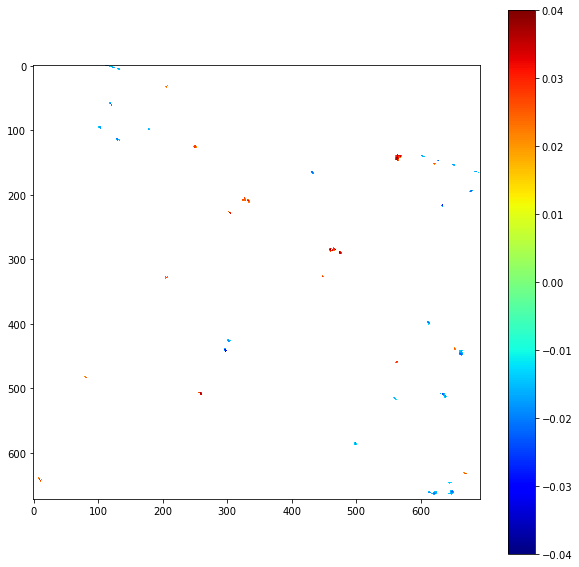

In [186]:
f = plt.figure(figsize=(10,10))
plt.imshow(up_data_both,cmap='jet',interpolation='none',vmin=-0.04,vmax=0.04)
plt.colorbar()

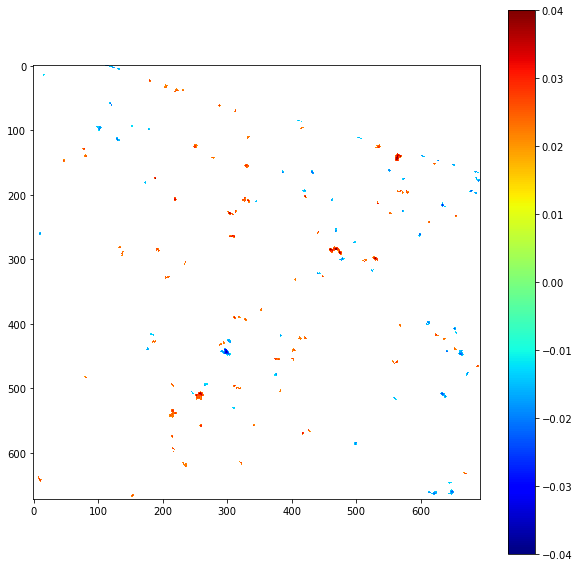

In [133]:
f = plt.figure(figsize=(10,10))
plt.imshow(data,cmap='jet',interpolation='none',vmin=-0.04,vmax=0.04)
plt.colorbar()